In [1]:
import matplotlib.pyplot as plt

#For bundle visualization and analysis
import circle_bundles as cb
from circle_bundles import RP2UnitVectorMetric as rp2_metric
cb.attach_bundle_viz_methods()

#For generating and visualizing synthetic datasets
import synthetic as sy

#For persistence computations
from ripser import ripser
from persim import plot_diagrams

#For computing local circular coordinates (optional)
from dreimac import CircularCoords


# Generate A Synthetic Dataset

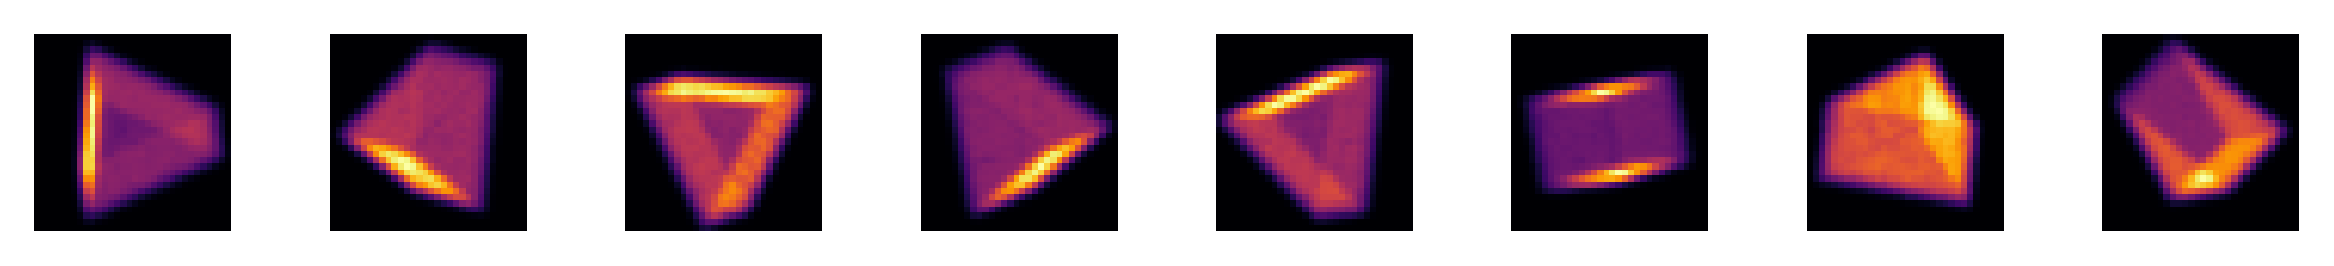

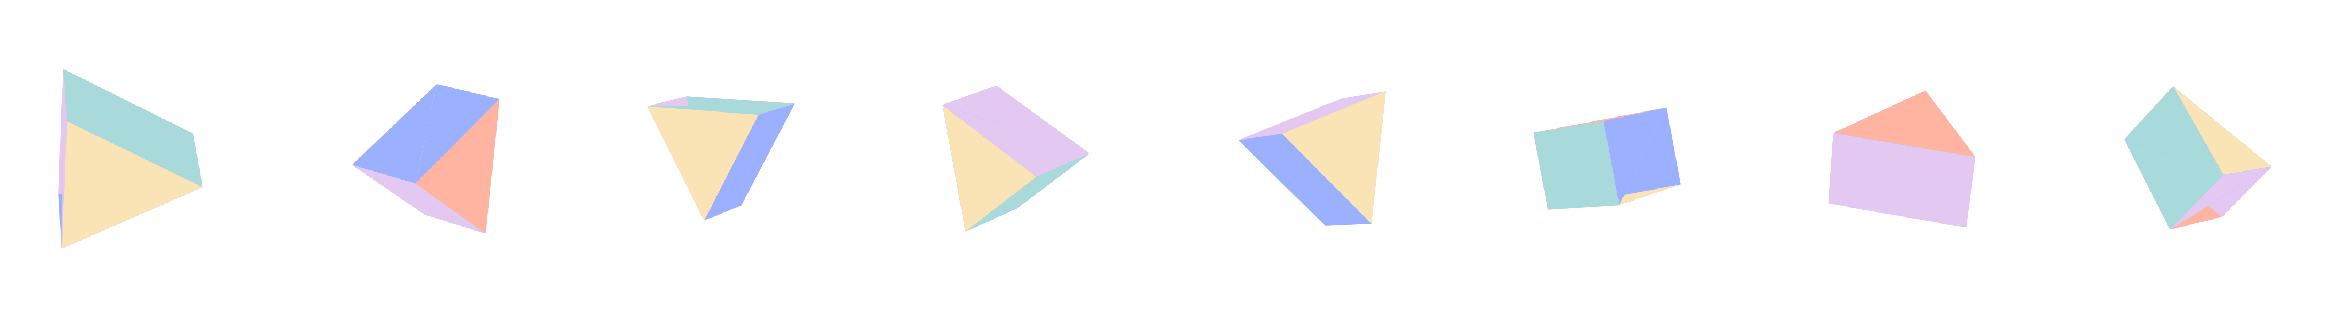

In [2]:
#Get a density
height = 1
radius = 1
grid_size = 32
sigma = 0.05
mesh, face_groups = sy.make_tri_prism()
density = sy.mesh_to_density(mesh, grid_size=grid_size, sigma=sigma)

vis_func = sy.make_density_visualizer(grid_size = grid_size)
mesh_vis = sy.make_tri_prism_visualizer(mesh, face_groups)

#View a visualization of the mesh

#SO3_data = np.array([np.eye(3).flatten()])
n_samples = 8
SO3_data = sy.sample_SO3(n_samples)[0]

density_sample = sy.rotate_density(density, SO3_data, grid_size = grid_size)
fig = cb.show_data_vis(density_sample, vis_func, max_samples = n_samples, n_cols = n_samples, sampling_method = 'first')
plt.show()

mesh_sample = sy.get_mesh_sample(mesh, SO3_data)
fig = cb.show_data_vis(mesh_sample, mesh_vis, max_samples = n_samples, n_cols = n_samples, sampling_method = 'first', pad_frac = 0.3)
plt.show()

In [3]:
#Generate the dataset

n_samples = 5000
SO3_data = sy.sample_SO3(n_samples)[0]

mesh_data = sy.get_mesh_sample(mesh, SO3_data)
data = sy.rotate_density(density, SO3_data, grid_size = grid_size)

print(f'Generated {n_samples} rotated triangle meshes.')

Generated 5000 rotated triangle meshes.


# Preliminary Analysis

In [ ]:
#Show a PCA visualization of the dataset
cb.show_pca(data, max_points = 5000)


In [ ]:
#Compute base projections
base_points = sy.get_density_axes(data)
print('Base projections computed.')

In [ ]:
#Show an interactive visualization of the projection mapping
app = cb.show_bundle_vis(base_points = base_points, 
                         data  = data, 
                         base_metric = rp2_metric, max_samples = 5000)


In [ ]:
# Run Ripser
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


# Bundle Analysis

## Open Cover

In [ ]:
#Construct an open cover of RP2
n_landmarks = 40
cover = cb.make_rp2_fibonacci_star_cover(base_points, n_pairs = n_landmarks)

summ = cover.summarize(plot = True)


In [ ]:
#Show a visualization of a 'fat fiber' of the projection map

center_ind = 579
r = 0.2
dist_mat = rp2_metric().pairwise(X=base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]

fiber_data = data[nearby_indices]
vis_data = mesh_data[nearby_indices]


fig = plt.figure(figsize=(18, 6), dpi=120)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

# PCA labeled with meshes
cb.fiber_vis(
    fiber_data,
    mesh_vis,
    vis_data=vis_data,
    max_images=500,
    zoom=0.08,
    ax=ax1,
    show=False,
)
ax1.set_title("Fiber PCA (Meshes)")

# PCA labeled with density projections
cb.fiber_vis(
    fiber_data,
    vis_func=vis_func,
    max_images=500,
    zoom=0.05,
    ax=ax2,
    show=False,
)
ax2.set_title("Fiber PCA (Densities)")

# Base visualization
cb.base_vis(
    base_points,
    center_ind,
    r,
    dist_mat,
    use_pca=False,
    ax=ax3,
    show=False,
)
ax3.set_title("Base neighborhood")

plt.tight_layout()
plt.show()


In [ ]:
#Try running circular coordinates on a single open set using Dreimac
j= 0
n_landmarks = 250
prime = 43
fiber_data = data[cover.U[j]]
patch_angles, n_warnings, n_lmks = cb.compute_circular_coords_dreimac(fiber_data, 
                                                                      n_landmarks_init = n_landmarks, 
                                                                      CircularCoords_cls = CircularCoords)

print(f'Retries: {n_warnings}, Number of landmarks used: {n_lmks}')
print('')
cb.show_pca(fiber_data, colors = patch_angles)



In [ ]:
#Show a sample of coordinatized densities from the fiber

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

fig, axes = cb.circle_vis(
    fiber_data,
    patch_angles,
    vis_func,
    per_circle=8,
    angle_range=None,      
    radius=1.0,            
    extent_factor=1.2,     
    figsize=6,
    dpi=75,
    zoom=0.13,             
    circle_linewidth=1.0,
    circle_color="black",
    ax = ax1,
)


fiber_meshes = mesh_data[cover.U[j]]
fig, axes = cb.circle_vis(
    fiber_meshes,
    patch_angles,
    mesh_vis,
    per_circle=8,
    angle_range=None,      
    radius=1.0,            
    extent_factor=1.2,     
    figsize=4,
    dpi=100,
    zoom=0.15,             
    circle_linewidth=1.0,
    circle_color="black",
    ax = ax2
)

plt.tight_layout()
plt.show()

## Characteristic Classes

In [ ]:
#Compute approximate local trivializations, transition matrices and characteristic classes

bundle = cb.build_bundle(
    data,
    cover,
    CircularCoords_cls=CircularCoords,  #optionally use sparse cc's
    show=True
)


In [ ]:
#Compute class persistence on the weights filtration of the nerve
pers = bundle.get_persistence(show = True)


In [ ]:
#Compute a global coordinatization map compatible with the maximal subcomplex
#on which the characteristic class representatives are coboundaries
triv_result = bundle.get_global_trivialization()

print('global coordinates computed.')


## Results and Visualizations

In [ ]:
#Show an interactive visualization of the bundle
fig = bundle.show_bundle(colors = triv_result.F)
plt.show()

In [ ]:
#Show a visualization of the 1-skeleton of the nerve of the cover
dist_mat = rp2_metric().pairwise(X = cover.landmarks, Y = cover.base_points)
inds = np.argmin(dist_mat, axis = 1)
node_data = mesh_data[inds]

node_labels = [f"{i+1}" for i in range(cover.landmarks.shape[0])]

fig, axes = cb.nerve_vis(
    cover,
    cochains={1:bundle.classes.sw1_O1},
    base_colors={0:'black', 1:'black', 2:'pink'},
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}},
    opacity=0,
    node_size=24,
    line_width=1,
    node_labels=None,
    fontsize=8,
    font_color='white',
    vis_func=mesh_vis,
    data=node_data,
    image_zoom=0.07,
    title='1-Skeleton Of The Nerve Of The Cover'
)
plt.show()


# Restriction To The Equator $\mathbb{RP}^{1}\subset \mathbb{RP}^{2}$

In [ ]:
#Get patches whose projection lie near the equator in RP2
eps = 0.1
eq_inds = np.abs(base_points[:,-1]) < eps
eq_data = bundle.data[eq_inds]
eq_base_angles = np.arctan2(base_points[eq_inds,1], base_points[eq_inds,0]) % (np.pi)


In [ ]:
# Show a visualization of the maximal subcomplex of N(U) on which the class reps become coboundaries

dist_mat = rp2_metric().pairwise(X=cover.landmarks, Y=cover.base_points)
inds = np.argmin(dist_mat, axis=1)
node_data = mesh_data[inds]

# Highlight the open sets which contain equator points
eq_sets = set(map(int, np.flatnonzero(cover.U[:, eq_inds].any(axis=1))))

max_triv = bundle.get_max_trivial_subcomplex()

# --- subcomplex simplices ---
sub_edges = [(int(i), int(j)) for (i, j) in max_triv.kept_edges]
sub_tris  = [(int(i), int(j), int(k)) for (i, j, k) in max_triv.kept_triangles]

# vertices actually appearing in the subcomplex
sub_verts = sorted({i for (a, b) in sub_edges for i in (a, b)} | {i for t in sub_tris for i in t})

# 0-cochain highlighting equator-containing sets (use int keys)
highlight_cochain = {j: int(j in eq_sets) for j in sub_verts}

node_labels = [f"{i+1}" for i in range(cover.landmarks.shape[0])]

fig, ax = cb.nerve_vis(
    cover, 
    vertices=sub_verts,           
    edges=sub_edges,              
    max_dim=1,                    
    cochains={1: bundle.classes.sw1_O1, 0: highlight_cochain},
    base_colors={0: "black", 1: "black", 2: "pink"},
    cochain_cmaps={
        1: {1: "blue", -1: "darkred"},
        0: {0: "darkgray", 1: "black"},
    },
    opacity=0,
    node_size=24,
    line_width=1,
    node_labels=None,
    fontsize=8,
    font_color="white",
    vis_func=mesh_vis,
    data=node_data,
    image_zoom=0.07,
    title='Subcomplex With Equator Sets Highlighted',
)
plt.show()


In [ ]:
#Construct a new bundle along the equator in RP2
eps = 0.15
eq_inds = np.abs(base_points[:,-1]) < eps

eq_data = bundle.data[eq_inds]

eq_base_angles = np.arctan2(base_points[eq_inds,1], base_points[eq_inds,0]) % (np.pi)
eq_base_points = np.array([np.cos(eq_base_angles), np.sin(eq_base_angles)]).T

#Set up an open cover of the base circle
n_landmarks = 12
landmarks = np.linspace(0, np.pi, n_landmarks, endpoint= False)
overlap = 1.99
radius = overlap* np.pi/(2*n_landmarks)

from circle_bundles.metrics import RP1AngleMetric as rp1_metric

eq_cover = cb.MetricBallCover(eq_base_angles, landmarks, radius, metric = rp1_metric())
eq_cover_data = eq_cover.build()

#Construct local circular coordinates and model transitions as O(2) matrices
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
#    CircularCoords_cls=CircularCoords,      #optionally use sparse cc's
    show=True,
)

#Get mesh data for visualization
eq_mesh_data = mesh_data[eq_inds]


In [ ]:
#Compute global coordinates on equator data using a filtration of the nerve
eq_triv_result = eq_bundle.get_global_trivialization()
print('Global coordinates computed.')

In [ ]:
#Show a visualization of the restricted nerve

#Compute a potential for the restricted orientation class
eq_subcomplex = eq_bundle.get_max_trivial_subcomplex()
edges = eq_subcomplex.kept_edges
Omega = eq_bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = eq_bundle.classes.omega_O1_used

fig = eq_bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()




In [ ]:
#Get a visualization of the data arranged by assigned coordinates using meshes
coords = np.array([eq_base_angles, eq_triv_result.F]).T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), dpi=200)

fig = cb.lattice_vis(
    eq_mesh_data,
    coords,
    mesh_vis, 
    per_row=7,          
    per_col=7,          
    figsize=10, 
    thumb_px=100,
    dpi=200,
    ax = ax1,
)

#Get a visualization of the data arranged by assigned coordinates using meshes
fig = cb.lattice_vis(
    eq_data,
    coords,
    vis_func, 
    per_row=7,          
    per_col=7,          
    figsize=10, 
    thumb_px=120,
    dpi=200,
    ax = ax2,
)
plt.show()
